

If running this demo in Google Colab, **Switch to GPU**:



*   Go to Edit → Notebook Settings
*   Choose GPU from Hardware Accelerator






# Installing SpinWalk

In [ ]:
%%bash
# install dependencies
apt-get install -y libboost-all-dev libhdf5-dev libtbb-dev

# clone SpinWalk
rm -rf SpinWalk
git clone --depth 1 https://github.com/aghaeifar/SpinWalk.git &> /dev/null

# build it
cd SpinWalk
cmake -B ./build
cmake --build ./build --config Release
cmake --install ./build

Reading package lists...
Building dependency tree...
Reading state information...
libboost-all-dev is already the newest version (1.74.0.3ubuntu7).
libhdf5-dev is already the newest version (1.10.7+repack-4ubuntu2).
libtbb-dev is already the newest version (2021.5.0-7ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
-- CMake version: 3.30.1
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found HDF5: /usr/lib/x86_64-linux-gnu/hdf5/serial/libhdf5_cpp.so;/usr/lib/x86_64-linux-gnu/hdf5/serial/libhdf5.so;/usr/lib/x8

In [1]:
%%bash
# test it runs and show help menu
echo "Running SpinWalk..."
spinwalk 

# show version
echo e "Print SpinWalk version..."
spinwalk --version

# print gpu info if available - note this command won't work if spinwalk is compiled without CUDA support
echo -e "\nPrint GPU info..."
spinwalk --gpu_info

Running SpinWalk...
Usage: spinwalk [OPTIONS] [SUBCOMMAND]

Options:
  -h,--help                             Print this help message and exit
  -v,--version                          Display program version information and exit
  -g,--gpu_info                         Print GPU information

Subcommands:
  sim                                   Run Monte-Carlo simulation
  phantom                               Generate numerical phantom
  config                                Generate configuration file
  diff_grad                             Generate diffusion gradient table

e Print SpinWalk version...
1.16.0

Print GPU info...
Driver version: 12060, CUDA version: 12060
Number of devices: 1
NVIDIA RTX A4000
-Compute Capability: 8.6
-Free GPU Memory: 14273 MB (out of 16002 MB)


# Generating Phantom

Here, **SpinWalk** generates a phantom containing spheres with a radius of 20 µm or less, mimicking cells. These spheres will occupy 50% of the total volume, and the phantom will have a field of view (FoV) of 600 µm. The phantom will be stored in the `phantoms` folder.

In [4]:
%%bash
echo "Print help menu for phantom generation..."
spinwalk phantom -h

Print help menu for phantom generation...
Generate numerical phantom
Usage: spinwalk phantom [OPTIONS]

Options:
  -h,--help                             Print this help message and exit
  -c,--cylinder                         Fill phantom with cylinders
  -s,--sphere                           Fill phantom with spheres
  -r,--radius FLOAT [50]                Radius of the cylinders/spheres in µm (negative value = allowing smaller radiuses too)
  -n,--orientation FLOAT [90]           Orientation of the cylinders in degree with respect to B0
  -v,--volume_fraction FLOAT [4]        Fraction of shapes volume to FoV volume in % <0.0 100.0>
  -f,--fov FLOAT:POSITIVE               Voxel field of view in µm (isotropic)
  -z,--resolution UINT:POSITIVE         Base resolution
  -d,--dchi FLOAT [1.1e-07]             Susceptibility difference between fully deoxygenated blood and tissue (default: 0.11e-6 in cgs units)
  -y,--oxy_level FLOAT [0.75]           Blood oxygenetation level <0.0 1.0> (-1 = 

In [1]:
%%bash
# Define the output directory
output_dir="./phantoms"
mkdir -p "$output_dir"

vol_frac=40
resolution=600
fov=600
radius=-20
oxy_level=-1

# Define the output file
output_file="${output_dir}/r${radius}_vf${vol_frac}_fov${fov}_res${resolution}.h5"
# Call the command with the variable parameter and redirect the output
spinwalk phantom -s -r "$radius" -v "$vol_frac" -f "$fov" -z "$resolution" -y "$oxy_level" -e 0 -o "$output_file"

# check phantoms are there
echo -e "\nList of existing phantoms in phantom folder..."
ls -l --block-size=M ./phantoms


 ____            _          __        __          _   _        
/ ___|   _ __   (_)  _ __   \ \      / /   __ _  | | | | __    
\___ \  | '_ \  | | | '_ \   \ \ /\ / /   / _` | | | | |/ /    
 ___) | | |_) | | | | | | |   \ V  V /   | (_| | | | |   <     
|____/  | .__/  |_| |_| |_|    \_/\_/     \__,_| |_| |_|\_\    
        |_|                                                    


SpinWalk Version: 1.16.0
Log file location: "/DATA/aaghaeifar/Nextcloud/Projects/microvascular/SpinWalk/demo/spinwalk_0.log"
Generating sphere phantom...
Generating (1/2) 100.00% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100/100 
Generating (2/2) 100.00% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168586/168586 
Done.

List of existing phantoms in phantom folder...
total 412M
-rw-r--r-- 1 aaghaeifar kyb 206M Dez  9 12:34 ph.h5
-rw-r--r-- 1 aaghaeifar kyb 206M Dez  9 12:39 r-20_vf40_fov600_res600.h5


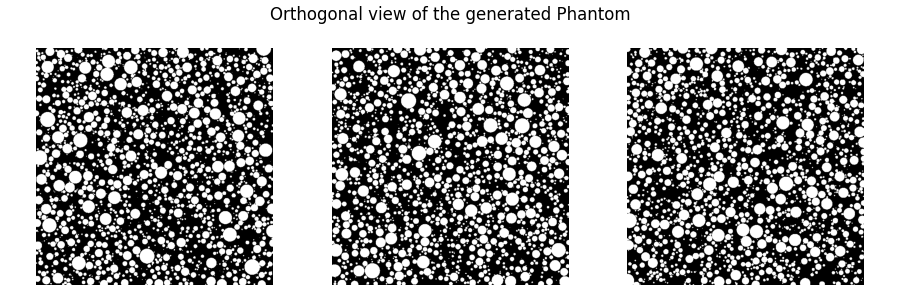

In [4]:
%matplotlib widget
# plot the generated phantoms
import h5py
import matplotlib.pyplot as plt

def plot_phantom(file_path, title=None):
    with h5py.File(file_path, "r") as f:
        mask = f["mask"][()]
        sz = tuple(dim // 2 for dim in mask.shape)
        # print orthogonal views
        fig, axes = plt.subplots(1, 3, figsize=(9, 3))
        axes[0].imshow(mask[:, :, sz[2]], cmap="gray")
        axes[0].axis("off")
        axes[1].imshow(mask[:, sz[1], :], cmap="gray")
        axes[1].axis("off")
        axes[2].imshow(mask[sz[0], :, :], cmap="gray")
        axes[2].axis("off")

        # title
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

# show the phantom
output_file= "./phantoms/r-20_vf40_fov600_res600.h5"
plot_phantom(output_file, title="Orthogonal view of the generated Phantom")


# Creating Configuration File
We will create multiple GRE configuration files and later update them to incorporate diffusion-sensitizing gradients.

In [5]:
%%bash
# help menu for generating config file
spinwalk config -h

Generate configuration file
Usage: spinwalk config [OPTIONS]

Options:
  -h,--help                             Print this help message and exit
  -s,--seq_name TEXT                    Sequence name: GRE, SE, bSSFP, default
  -p,--phantoms TEXT:FILE ...           Path to phantom files as many as you want. e.g. -p phantom1.h5 phantom2.h5 ... phantomN.h5
  -e,--TE UINT:POSITIVE                 Echo time in µs
  -t,--timestep UINT:POSITIVE           timestep in µs
  -o,--output TEXT                      Path to save the configuration file


## GRE configuration file as a base

In [42]:
%%bash
for ((i=0; i<=5000; i+=100))
do
  spinwalk config -s GRE --TE 60000 -t 50 -p ../phantoms/r-20_vf40_fov600_res600.h5 -o ./dwi/gre_$i.ini
  sed -i "s/SEQ_NAME = gre/SEQ_NAME = bvalue$i/g" ./dwi/gre_$i.ini
done

# prolong relaxation time in default config. This file is generated with gre config and serves as parent config for all GREs. 
sed -i 's/T1\[0\] = 2200/T1\[0\] = 9999999/g' ./dwi/default_config.ini
sed -i 's/T1\[1\] = 2200/T1\[1\] = 9999999/g' ./dwi/default_config.ini
sed -i 's/T2\[0\] = 41/T2\[0\] = 9999999/g' ./dwi/default_config.ini
sed -i 's/T2\[1\] = 41/T2\[1\] = 9999999/g' ./dwi/default_config.ini

# and make permeable membranes -> free diffusion
sed -i 's/P_XY\[0\] = 1.0 0.0/P_XY\[0\] = 1.0 1.0/g' ./dwi/default_config.ini
sed -i 's/P_XY\[1\] = 0.0 1.0/P_XY\[1\] = 1.0 1.0/g' ./dwi/default_config.ini

 ____            _          __        __          _   _        
/ ___|   _ __   (_)  _ __   \ \      / /   __ _  | | | | __    
\___ \  | '_ \  | | | '_ \   \ \ /\ / /   / _` | | | | |/ /    
 ___) | | |_) | | | | | | |   \ V  V /   | (_| | | | |   <     
|____/  | .__/  |_| |_| |_|    \_/\_/     \__,_| |_| |_|\_\    
        |_|                                                    


SpinWalk Version: 1.16.0
Log file location: "/DATA/aaghaeifar/Nextcloud/Projects/microvascular/SpinWalk/demo/spinwalk_0.log"
Configuration file is generated in /DATA/aaghaeifar/Nextcloud/Projects/microvascular/SpinWalk/demo/dwi/gre_0.ini
 ____            _          __        __          _   _        
/ ___|   _ __   (_)  _ __   \ \      / /   __ _  | | | | __    
\___ \  | '_ \  | | | '_ \   \ \ /\ / /   / _` | | | | |/ /    
 ___) | | |_) | | | | | | |   \ V  V /   | (_| | | | |   <     
|____/  | .__/  |_| |_| |_|    \_/\_/     \__,_| |_| |_|\_\    
        |_|                                             

|____/  | .__/  |_| |_| |_|    \_/\_/     \__,_| |_| |_|\_\    
        |_|                                                    


SpinWalk Version: 1.16.0
Log file location: "/DATA/aaghaeifar/Nextcloud/Projects/microvascular/SpinWalk/demo/spinwalk_0.log"
Configuration file is generated in /DATA/aaghaeifar/Nextcloud/Projects/microvascular/SpinWalk/demo/dwi/gre_300.ini
 ____            _          __        __          _   _        
/ ___|   _ __   (_)  _ __   \ \      / /   __ _  | | | | __    
\___ \  | '_ \  | | | '_ \   \ \ /\ / /   / _` | | | | |/ /    
 ___) | | |_) | | | | | | |   \ V  V /   | (_| | | | |   <     
|____/  | .__/  |_| |_| |_|    \_/\_/     \__,_| |_| |_|\_\    
        |_|                                                    


SpinWalk Version: 1.16.0
Log file location: "/DATA/aaghaeifar/Nextcloud/Projects/microvascular/SpinWalk/demo/spinwalk_0.log"
Configuration file is generated in /DATA/aaghaeifar/Nextcloud/Projects/microvascular/SpinWalk/demo/dwi/gre_400.ini
 ___

## Adding diffusion sensitizing gradients (PGSE like)

In [7]:
%%bash
# help menu for generating DWI
spinwalk dMRI -h

Generate diffusion gradient table
Usage: spinwalk dMRI [OPTIONS]

Options:
  -h,--help                             Print this help message and exit
  -b,--bvalue FLOAT                     b-value (s/mm²)
  -v,--bvector FLOAT x 3                Gradient direction: X Y Z, e.g. 0.267 0.534 0.801
  -d,--delta UINT x 3                   start time, δ and Δ in ms, e.g. 10 3 5 
  -c,--config TEXT:FILE                 input config file to insert PGSE gradients and excitation and refocusing RF


In [43]:
%%bash
for ((bvalue=0; bvalue<=5000; bvalue+=100))
do
  spinwalk dMRI -b $bvalue -v 1 0 0 -d  15 10 20 -c ./dwi/gre_$bvalue.ini
done

 ____            _          __        __          _   _        
/ ___|   _ __   (_)  _ __   \ \      / /   __ _  | | | | __    
\___ \  | '_ \  | | | '_ \   \ \ /\ / /   / _` | | | | |/ /    
 ___) | | |_) | | | | | | |   \ V  V /   | (_| | | | |   <     
|____/  | .__/  |_| |_| |_|    \_/\_/     \__,_| |_| |_|\_\    
        |_|                                                    


SpinWalk Version: 1.16.0
Log file location: "/DATA/aaghaeifar/Nextcloud/Projects/microvascular/SpinWalk/demo/spinwalk_0.log"
Generating PGSE for b-value = 0 s/mm²
Diffusion gradient table is generated successfully.
 ____            _          __        __          _   _        
/ ___|   _ __   (_)  _ __   \ \      / /   __ _  | | | | __    
\___ \  | '_ \  | | | '_ \   \ \ /\ / /   / _` | | | | |/ /    
 ___) | | |_) | | | | | | |   \ V  V /   | (_| | | | |   <     
|____/  | .__/  |_| |_| |_|    \_/\_/     \__,_| |_| |_|\_\    
        |_|                                                    


SpinWalk Vers

 ____            _          __        __          _   _        
/ ___|   _ __   (_)  _ __   \ \      / /   __ _  | | | | __    
\___ \  | '_ \  | | | '_ \   \ \ /\ / /   / _` | | | | |/ /    
 ___) | | |_) | | | | | | |   \ V  V /   | (_| | | | |   <     
|____/  | .__/  |_| |_| |_|    \_/\_/     \__,_| |_| |_|\_\    
        |_|                                                    


SpinWalk Version: 1.16.0
Log file location: "/DATA/aaghaeifar/Nextcloud/Projects/microvascular/SpinWalk/demo/spinwalk_0.log"
Generating PGSE for b-value = 400 s/mm²
Diffusion gradient table is generated successfully.
 ____            _          __        __          _   _        
/ ___|   _ __   (_)  _ __   \ \      / /   __ _  | | | | __    
\___ \  | '_ \  | | | '_ \   \ \ /\ / /   / _` | | | | |/ /    
 ___) | | |_) | | | | | | |   \ V  V /   | (_| | | | |   <     
|____/  | .__/  |_| |_| |_|    \_/\_/     \__,_| |_| |_|\_\    
        |_|                                                    


SpinWalk Ve

# Simulation

SpinWalk will read all the provided config files and simulate them sequentially.

In [44]:
%%bash
list_of_configs=""
for ((bvalue=0; bvalue<=5000; bvalue+=100))
do
  list_of_configs+="./dwi/gre_$bvalue.ini "
done

spinwalk sim -c $list_of_configs

 ____            _          __        __          _   _        
/ ___|   _ __   (_)  _ __   \ \      / /   __ _  | | | | __    
\___ \  | '_ \  | | | '_ \   \ \ /\ / /   / _` | | | | |/ /    
 ___) | | |_) | | | | | | |   \ V  V /   | (_| | | | |   <     
|____/  | .__/  |_| |_| |_|    \_/\_/     \__,_| |_| |_|\_\    
        |_|                                                    


SpinWalk Version: 1.16.0
Log file location: "/DATA/aaghaeifar/Nextcloud/Projects/microvascular/SpinWalk/demo/spinwalk_0.log"
Running simulation for 51 config(s)...

<gre_0.ini>
Simulating 100.00% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 
<gre_100.ini>
Simulating 100.00% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 
<gre_200.ini>
Simulating 100.00% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 
<gre_300.ini>
Simulating 100.00% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 
<gre_400.ini>
Simulating 100.00% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 
<gre_500.ini>
Simulating 100.00% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 
<gre_600.ini>
Simulating 100.00% ━━━━

In [45]:
%%bash
# cat spinwalk_0.log
ls ./dwi/outputs

bvalue0_r-20_vf40_fov600_res600.h5
bvalue1000_r-20_vf40_fov600_res600.h5
bvalue100_r-20_vf40_fov600_res600.h5
bvalue1100_r-20_vf40_fov600_res600.h5
bvalue1200_r-20_vf40_fov600_res600.h5
bvalue1300_r-20_vf40_fov600_res600.h5
bvalue1400_r-20_vf40_fov600_res600.h5
bvalue1500_r-20_vf40_fov600_res600.h5
bvalue1600_r-20_vf40_fov600_res600.h5
bvalue1700_r-20_vf40_fov600_res600.h5
bvalue1800_r-20_vf40_fov600_res600.h5
bvalue1900_r-20_vf40_fov600_res600.h5
bvalue2000_r-20_vf40_fov600_res600.h5
bvalue200_r-20_vf40_fov600_res600.h5
bvalue2100_r-20_vf40_fov600_res600.h5
bvalue2200_r-20_vf40_fov600_res600.h5
bvalue2300_r-20_vf40_fov600_res600.h5
bvalue2400_r-20_vf40_fov600_res600.h5
bvalue2500_r-20_vf40_fov600_res600.h5
bvalue2600_r-20_vf40_fov600_res600.h5
bvalue2700_r-20_vf40_fov600_res600.h5
bvalue2800_r-20_vf40_fov600_res600.h5
bvalue2900_r-20_vf40_fov600_res600.h5
bvalue3000_r-20_vf40_fov600_res600.h5
bvalue300_r-20_vf40_fov600_res600.h5
bvalue3100_r-20_vf40_fov600_res600.h5
bvalue3200_r-20_vf

In [47]:
import os
import numpy as np
import h5py

tissue_type = 0 # 0 = extra-vascular, 1 = intra-vascular, [0,1] = combined
results_dir = './dwi/outputs/'
b_values = np.arange(0, 5100, 100)

def read_results(filename):
    signal_magnitude = []
    filepath = os.path.join(results_dir, f'{filename}.h5')
    with h5py.File(filepath, 'r') as h5:
        M = np.array(h5['M'])
        T = np.array(h5['T'])
        S = np.array(h5['scales'])
        for ids, s in enumerate(S):
            mask = (T[ids, :, 0, 0] == tissue_type)
            M_f = M[ids, mask, 0, :]
            M_f = np.mean(M_f[...,0:2], axis=0)
            signal_magnitude.append(np.linalg.norm(M_f))
    return signal_magnitude


############
signal_magnitude = []
for b in b_values:
    filename = f'bvalue{b}_r-20_vf40_fov600_res600'
    signal_magnitude.append(read_results(filename))
signal_magnitude = np.array(signal_magnitude)
print(signal_magnitude.shape)

(51, 1)


Fitted diffusion coefficient   : 9.850617352132752e-08
Simulated diffusion coefficient: 1e-09


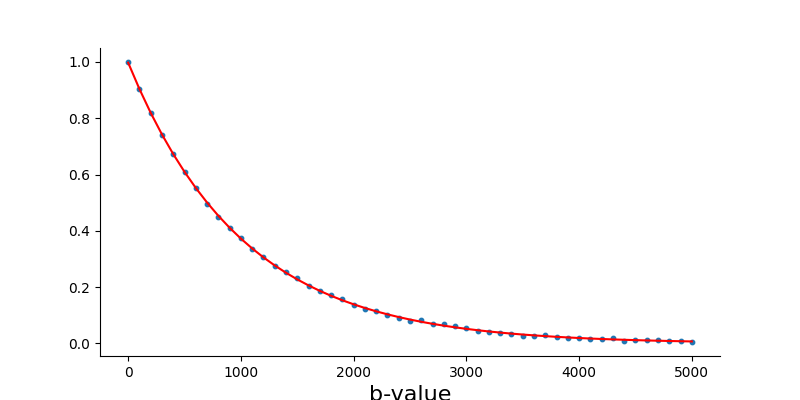

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the model function (exponential of the form exp1: a * exp(b * x))
def exp1(bvalue, a, D):
    return a * np.exp(-bvalue * D)

# Set initial parameters (StartPoint in MATLAB)
initial_params = [988912.916299669, -0.000461964926600495]
# Set additional options (equivalent to MATLAB fit options)
options = {'maxfev': 6000, 'ftol': 1e-9, 'xtol': 1e-9}

# Fit the model to the data
popt, pcov = curve_fit(exp1, b_values.flatten().astype(float), signal_magnitude.flatten().astype(float), p0=initial_params, **options)
# Extract fitting parameters and goodness of fit
a, D = popt

print(f"Fitted diffusion coefficient   :", D * 1e-4) # convert mm^2/s to m^2/ms
print(f"Simulated diffusion coefficient: {1e-9}")

plt.rcParams['svg.fonttype'] = 'none' # to embed fonts in SVG output
plt.close('all')
BV   = [2, 5]
cmap = plt.get_cmap('Set2')
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(b_values, signal_magnitude, s=10)
ax.plot(b_values, exp1(b_values, a, D), 'r-')
ax.set_xlabel('b-value', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
